In [1]:
# %% import package to use
import datatable
import pandas as pd
from IPython.display import display
import numpy as np
import os
from sklearn.metrics import r2_score
import xgboost as xgb
pd.set_option('display.max_columns', None)

In [2]:
df_results_rf = pd.read_csv('./grid_search/results_rf_reg.csv', index_col='Unnamed: 0')
df_results_linear = pd.read_csv('./grid_search/results_linear_reg.csv', index_col='Unnamed: 0')
df_results_elastic = pd.read_csv('./grid_search/results_elastic_reg.csv', index_col='Unnamed: 0')

rf_best_param = df_results_rf.loc[df_results_rf['rank_test_score'] == 1].iloc[-1]
linear_best_param = df_results_linear.loc[df_results_linear['rank_test_score'] == 1].iloc[-1]
elastic_best_param = df_results_elastic.loc[df_results_elastic['rank_test_score'] == 1].iloc[-1]


import pickle
with open('./grid_search/results_xg_reg.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)
    
df_results_xg = pd.DataFrame()
for condition in results:
    df_results_xg = pd.concat((df_results_xg, pd.DataFrame(results[condition])), axis=0)
xg_best_param = df_results_xg[df_results_xg['mean_score'] == df_results_xg['mean_score'].max()][['max_depth', 'learning_rate', 'lambda', 'gamma', 'scores']].reset_index(drop=True)



In [3]:
# %% Load dataset
DATA_PATH = "/home/lkh256/Studio/VO2max_Prediction/Data"
df_init = datatable.fread(os.path.join(DATA_PATH, 'general_eq.csv'), encoding='utf-8-sig', na_strings=['', 'NA']).to_pandas()
df_init['SM_DATE'] = df_init['SM_DATE'].astype('datetime64')

print(df_init.isnull().sum())

df_init = df_init.fillna(df_init.median())

print("Number of samples = {}".format(len(df_init)))

# %% Check missings
print("Check their is any missing variables in dataset: \n", df_init.isnull().sum())

# %% Sort visit number and select rows to analysis
df_init['visit_num'] = df_init.groupby(['HPCID'])['SM_DATE'].apply(pd.Series.rank)
df_selected = df_init[df_init['visit_num'] == 1].reset_index(drop=True)
print("Number of eq case = {}".format(len(df_selected)))


feature_mask = ['AGE', 'sex', 'BMI', 'rest_HR', 'MVPA']

# %%
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_selected,  
                                       random_state=1005, 
                                       stratify=df_selected['death'], 
                                       test_size=0.2)

print("Train set size = {}".format(len(train_set)))
print("Test set size = {}".format(len(test_set)))

X_train = train_set[feature_mask].values
y_train = train_set['VO2max'].values
dtrain = xgb.DMatrix(X_train, label=y_train)

X_test = test_set[feature_mask].values
y_test = test_set['VO2max'].values
dtest = xgb.DMatrix(X_test, label=y_test)


SM_DATE                 0
HPCID                   0
sex                     0
AGE                     0
percentage_fat          0
Height                  0
Weight                  0
BMI                     0
MVPA                    0
rest_HR                 0
Smoke                   0
CRF                     0
비만도                     0
Muscle_mass             0
복부지방율                   0
부종검사                    0
Muscle_mass(RA)         0
Muscle_mass(LA)         0
Muscle_mass(BODY)       0
Muscle_mass(RL)         0
Muscle_mass(LL)         0
체지방량                    0
체수분량                    0
제지방량                    0
CRP                  1099
CHOLESTEROL           203
TG                    203
max_heart_rate          0
BMI_cal                 0
ASMI                    0
VO2max                  0
death                   0
delta_time              0
Diabetes                0
Hypertension            0
HTN_med                 0
Hyperlipidemia          0
Hepatatis               0
ALC         

## Random Forest

In [4]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(criterion='mae', max_features='log2', min_samples_split=4, n_estimators=500, n_jobs=-1)

feature_mask = ['AGE', 'sex', 'BMI', 'rest_HR', 'MVPA']

rf_reg.fit(train_set[feature_mask], train_set['VO2max'])

print("Train R^2 Score : ", r2_score(y_pred=rf_reg.predict(train_set[feature_mask]), y_true=train_set['VO2max']))
print("Test R^2 Score", r2_score(y_pred=rf_reg.predict(test_set[feature_mask]), y_true=test_set['VO2max']))



Train R^2 Score :  0.7722781838307763
Test R^2 Score 0.413584233887239


## Linear Regression

In [5]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression(normalize=False)

feature_mask = ['AGE', 'sex', 'BMI', 'rest_HR', 'MVPA']

linear_reg.fit(train_set[feature_mask], train_set['VO2max'])

print("Train R^2 Score : ", r2_score(y_pred=linear_reg.predict(train_set[feature_mask]), y_true=train_set['VO2max']))
print("Test R^2 Score", r2_score(y_pred=linear_reg.predict(test_set[feature_mask]), y_true=test_set['VO2max']))


Train R^2 Score :  0.4605994799870645
Test R^2 Score 0.44995384532844174


## Elastic Network

In [6]:
from sklearn.linear_model import ElasticNet

elastic_reg = ElasticNet(alpha=0, l1_ratio=0, normalize=False, selection='random')

elastic_reg.fit(train_set[feature_mask], train_set['VO2max'])

print("Train R^2 Score : ", r2_score(y_pred=elastic_reg.predict(train_set[feature_mask]), y_true=train_set['VO2max']))
print("Test R^2 Score", r2_score(y_pred=elastic_reg.predict(test_set[feature_mask]), y_true=test_set['VO2max']))

Train R^2 Score :  0.4605994799870645
Test R^2 Score 0.44995384532844185
<ipython-input-6-2801877dc3a8>:5: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  elastic_reg.fit(train_set[feature_mask], train_set['VO2max'])
/home/lkh256/anaconda3/envs/VO2max/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/lkh256/anaconda3/envs/VO2max/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48408.7264597106, tolerance: 17.949084090074567
  model = cd_fast.enet_coordinate_descent(


## XGBoost

In [7]:
import xgboost as xgb

params = {'objective': 'reg:squarederror',
                            'eval_metric': 'rmse',
                            'tree_method': 'gpu_hist', 
                            'gpu_id': '0',
                            'learning_rate': 0.001, 
                            'max_depth': 3,
                            'lambda': 3,
                            'gamma': 0.1}

model_xgb = xgb.train(params, dtrain, 
                    num_boost_round=20000, 
                    evals=[(dtest, 'test')], 
                    verbose_eval=0, 
                    early_stopping_rounds=1000)

print("Train R^2 Score", r2_score(y_train, model_xgb.predict(dtrain)))
print("Test R^2 Score", r2_score(y_test, model_xgb.predict(dtest)))

Train R^2 Score 0.4958892937043483
Test R^2 Score 0.45761728910318744


# Visualization

In [9]:
best_results_rf = pd.DataFrame(rf_best_param["split0_test_score":"split9_test_score"].values, columns=['scores'])
best_results_rf['model'] = 'Random Forest'
best_results_linear = pd.DataFrame(linear_best_param["split0_test_score":"split9_test_score"].values, columns=['scores'])
best_results_linear['model'] = 'Linear Regression'
best_results_elastic = pd.DataFrame(elastic_best_param["split0_test_score":"split9_test_score"].values, columns=['scores'])
best_results_elastic['model'] = 'Elastic'
best_results_xg = xg_best_param[['scores']]
best_results_xg['model'] = 'XG Boost'

best_results = pd.concat((best_results_rf, best_results_linear, best_results_elastic, best_results_xg), axis=0)

<ipython-input-9-8cd3efe5cc94>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_results_xg['model'] = 'XG Boost'


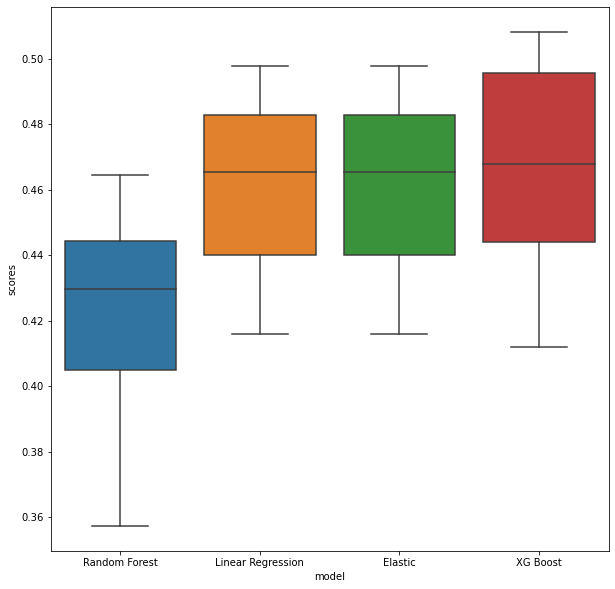

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.boxplot(x='model', y='scores', data=best_results)
plt.show()


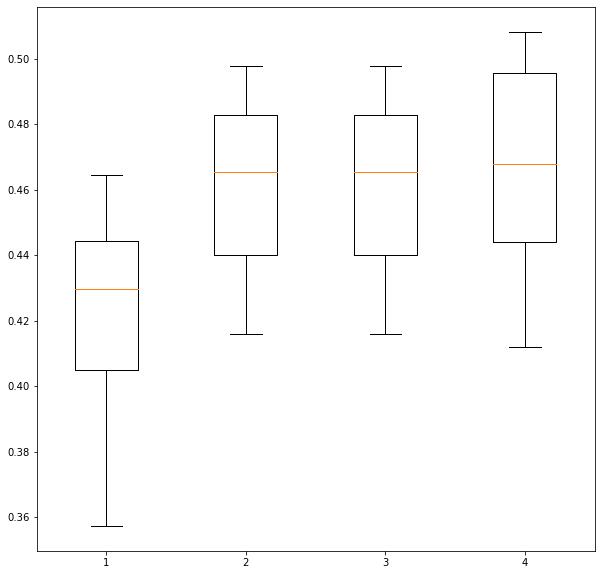

In [11]:
data = [best_results.loc[best_results['model'] == 'Random Forest', 'scores'], 
best_results.loc[best_results['model'] == 'Linear Regression', 'scores'], 
best_results.loc[best_results['model'] == 'Elastic', 'scores'],
best_results.loc[best_results['model'] == 'XG Boost', 'scores']]
plt.figure(figsize=(10, 10))
plt.boxplot(data)
plt.show()

### One-way ANOVA

In [19]:
from statsmodels.stats.oneway import anova_oneway
from statsmodels.stats.multitest import multipletests

print(anova_oneway(data=best_results['scores'], groups=best_results['model'], use_var='unequal', welch_correction=True))
print(multipletests)

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 3.349183665311434
pvalue = 0.03963019251899185
df = (3.0, 19.97376002780263)
df_num = 3.0
df_denom = 19.97376002780263
nobs_t = 40.0
n_groups = 4
means = [0.45926161 0.45926161 0.42422323 0.46785644]
nobs = [10. 10. 10. 10.]
vars_ = [0.0008549  0.0008549  0.00107353 0.00105292]
use_var = unequal
welch_correction = True
tuple = (3.349183665311434, 0.03963019251899185)

### Bonferroni Correction

In [30]:
from statsmodels.sandbox.stats.multicomp import MultiComparison
import scipy.stats
comp = MultiComparison(best_results['scores'], best_results['model'])
test_result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
test_result[0]

group1,group2,stat,pval,pval_corr,reject
Elastic,Linear Regression,-0.0,1.0,1.0,False
Elastic,Random Forest,2.5231,0.0213,0.1276,False
Elastic,XG Boost,-0.6223,0.5416,1.0,False
Linear Regression,Random Forest,2.5231,0.0213,0.1276,False
Linear Regression,XG Boost,-0.6223,0.5416,1.0,False
Random Forest,XG Boost,-2.9922,0.0078,0.0469,True


# Testset Metric

In [34]:
r2_rf_test = r2_score(y_pred=rf_reg.predict(test_set[feature_mask]), y_true=test_set['VO2max'])
r2_linear_test = r2_score(y_pred=linear_reg.predict(test_set[feature_mask]), y_true=test_set['VO2max'])
r2_elastic_test = r2_score(y_pred=elastic_reg.predict(test_set[feature_mask]), y_true=test_set['VO2max'])
r2_xg_test = r2_score(y_pred=model_xgb.predict(dtest), y_true=test_set['VO2max'])
print(r2_rf_test)
print(r2_linear_test)
print(r2_elastic_test)
print(r2_xg_test)

0.413584233887239
0.44995384532844174
0.44995384532844185
0.45761728910318744


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Random Forest v.s. Linear Regression: t-test independent samples with Bonferroni correction, P_val=1.276e-01 stat=-2.523e+00
Linear Regression v.s. Elastic: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=1.698e-14
Elastic v.s. XG Boost: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-6.223e-01
Random Forest v.s. Elastic: t-test independent samples with Bonferroni correction, P_val=1.276e-01 stat=-2.523e+00
Linear Regression v.s. XG Boost: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-6.223e-01
Random Forest v.s. XG Boost: t-test independent samples with Bonferroni correction, P_val=4.690e-02 stat=-2.992e+00


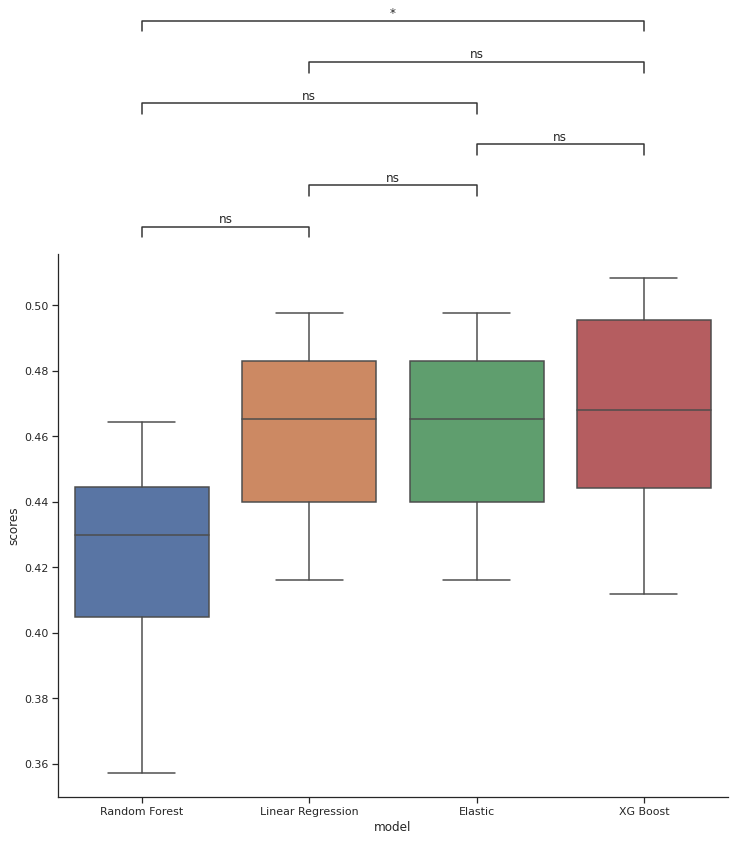

In [43]:
from statannot import add_stat_annotation
from itertools import combinations
import seaborn as sns
sns.set(style='ticks')

list_model = ["Random Forest", "Linear Regression", "Elastic", 'XG Boost']

oder = combinations(list_model, 2)
plt.figure(figsize=(12,10))
x = 'model'
y = 'scores'
order = list(list_model)
ax = sns.boxplot(data=best_results, x=x, y=y, order=order)
ax, test_results = add_stat_annotation(ax, data=best_results, x=x, y=y, order=list_model,
                                   box_pairs=oder,
                                   test='t-test_ind', text_format='star', loc='outside', verbose=2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
sns.despine()